In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os

PROJECT = "/content/drive/MyDrive/SmartSpend/smart-spend"   # <-- set your folder
os.chdir(PROJECT)

print("Current working directory:")
!pwd

print("Project folder content:")
!ls -R


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current working directory:
/content/drive/MyDrive/SmartSpend/smart-spend
Project folder content:
.:
data  src

./data:
test_clean.csv	test_noisy.csv	transactions.csv

./src:
load_and_split.ipynb  new2.ipynb


In [6]:
# Cell 1: Setup & load data
import os
import random
import json
import pandas as pd
import numpy as np

# Reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# File paths (adjust if your files are elsewhere)
DATA_PATH = "/content/drive/MyDrive/SmartSpend/smart-spend/data/transactions.csv"
TAXONOMY_PATH = "categories.json"  # optional, but recommended

# Load dataset
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"{DATA_PATH} not found. Please put your transactions.csv in the notebook folder.")

df = pd.read_csv(DATA_PATH)

# Load taxonomy if available
taxonomy = {}
if os.path.exists(TAXONOMY_PATH):
    with open(TAXONOMY_PATH, "r", encoding="utf-8") as f:
        taxonomy = json.load(f)
else:
    print(f"Warning: {TAXONOMY_PATH} not found. You can create one to make categories editable.")

# Quick sanity checks / preview
print("Dataset shape:", df.shape)
print("\nFirst 8 rows:")
display(df.head(8))

# Ensure expected columns exist
required_cols = {"merchant", "category"}
if not required_cols.issubset(set(df.columns)):
    raise ValueError(f"transactions.csv must contain columns: {required_cols}. Found: {df.columns.tolist()}")

# Category distribution
print("\nCategory distribution (value counts):")
display(df['category'].value_counts())

# Show taxonomy (if loaded)
if taxonomy:
    print("\nLoaded taxonomy (sample):")
    # show up to 10 categories
    for i, (cat, examples) in enumerate(taxonomy.items()):
        if i >= 10:
            break
        print(f"  - {cat}: examples -> {examples[:5]}")
else:
    print("\nNo taxonomy file loaded. You can add categories.json to allow admin editing of taxonomy.")


Dataset shape: (477, 2)

First 8 rows:


,merchant,category
0,Starbucks Coffee,Food
1,McDonalds,Food
2,Subway Sandwich,Food
3,KFC Order,Food
4,Dominos Pizza,Food
5,Pizza Hut,Food
6,Burger King,Food
7,Cafe Coffee Day,Food



Category distribution (value counts):


,count
category,
Food,60
Shopping,60
Bills,60
Groceries,60
Entertainment,60
Travel,59
Fuel,59
Healthcare,59



No taxonomy file loaded. You can add categories.json to allow admin editing of taxonomy.


In [7]:
# Cell 2: text preprocessing + train/test split

from sklearn.model_selection import train_test_split

# Clean category labels (IMPORTANT)
df["category"] = df["category"].astype(str).str.strip()

# Check cleaned category distribution
print("Cleaned category distribution:")
display(df["category"].value_counts())

# Features & target
X = df["merchant"]
y = df["category"]

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTrain size:", len(X_train))
print("Test size:", len(X_test))


Cleaned category distribution:


,count
category,
Food,60
Shopping,60
Bills,60
Groceries,60
Entertainment,60
Travel,59
Fuel,59
Healthcare,59



Train size: 381
Test size: 96


In [8]:
# Cell 3: TF-IDF vectorization + model training

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words="english",   # removes common useless words like "the", "and", etc.
    ngram_range=(1,2),      # unigrams + bigrams → improves accuracy
    min_df=2                # ignore very rare words
)

# Fit TF-IDF on training data
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform test data
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF fitted.")
print("Training vector shape:", X_train_tfidf.shape)
print("Test vector shape:", X_test_tfidf.shape)

# Train Logistic Regression model
model = LogisticRegression(
    max_iter=200,
    class_weight="balanced",   # handles class imbalance safely
    solver="lbfgs",
    n_jobs=-1
)

model.fit(X_train_tfidf, y_train)

print("\nModel training completed successfully.")


TF-IDF fitted.
Training vector shape: (381, 174)
Test vector shape: (96, 174)

Model training completed successfully.


=== Classification Report ===
               precision    recall  f1-score   support

        Bills       0.50      0.17      0.25        12
Entertainment       0.62      0.67      0.64        12
         Food       0.31      0.67      0.42        12
         Fuel       0.91      0.83      0.87        12
    Groceries       0.83      0.42      0.56        12
   Healthcare       0.90      0.75      0.82        12
     Shopping       0.62      0.67      0.64        12
       Travel       0.77      0.83      0.80        12

     accuracy                           0.62        96
    macro avg       0.68      0.62      0.62        96
 weighted avg       0.68      0.62      0.62        96



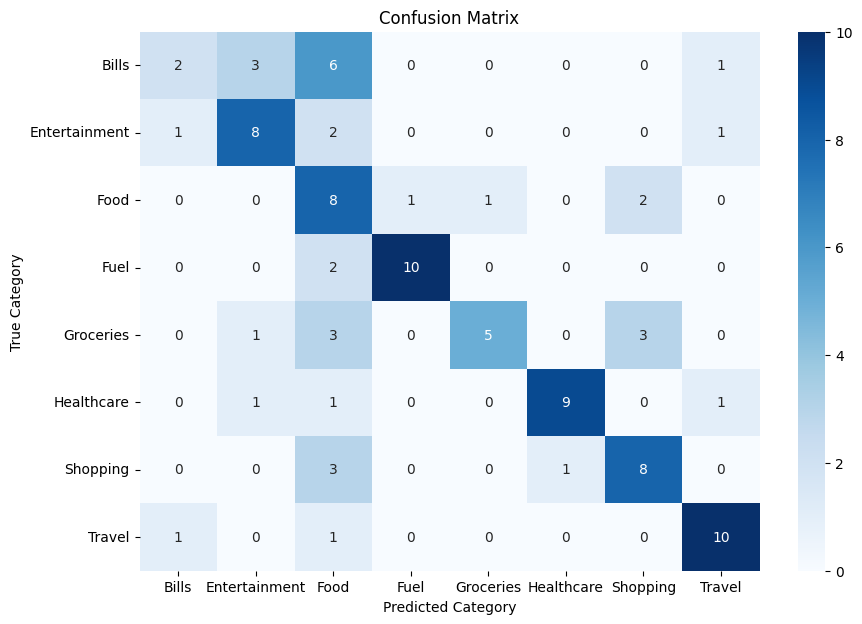

In [9]:
# Cell 4: Evaluation - F1 Score, Classification Report & Confusion Matrix

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred = model.predict(X_test_tfidf)

# Full classification report (precision, recall, f1)
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=sorted(df["category"].unique()))

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(df["category"].unique()),
            yticklabels=sorted(df["category"].unique()))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Category")
plt.ylabel("True Category")
plt.show()


In [10]:
# Cell 6: Load Sentence-BERT & Encode Merchant Text

from sentence_transformers import SentenceTransformer
import numpy as np

# Load the SBERT model (fast + accurate)
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

print("Encoding text using SBERT...")

# Encode train & test merchants
X_train_emb = sbert_model.encode(X_train.tolist(), convert_to_numpy=True)
X_test_emb = sbert_model.encode(X_test.tolist(), convert_to_numpy=True)

print("SBERT encoding completed!")
print("Training embeddings shape:", X_train_emb.shape)
print("Test embeddings shape:", X_test_emb.shape)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Encoding text using SBERT...
SBERT encoding completed!
Training embeddings shape: (381, 384)
Test embeddings shape: (96, 384)


In [11]:
# Cell 7: Train classifier on SBERT embeddings

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    solver="lbfgs"
)

print("Training classifier on SBERT embeddings...")
clf.fit(X_train_emb, y_train)
print("Training completed!")


Training classifier on SBERT embeddings...
Training completed!


=== SBERT Classification Report ===
               precision    recall  f1-score   support

        Bills       0.82      0.75      0.78        12
Entertainment       0.83      0.83      0.83        12
         Food       0.75      0.50      0.60        12
         Fuel       0.92      0.92      0.92        12
    Groceries       0.67      0.67      0.67        12
   Healthcare       0.83      0.83      0.83        12
     Shopping       0.69      0.92      0.79        12
       Travel       0.85      0.92      0.88        12

     accuracy                           0.79        96
    macro avg       0.79      0.79      0.79        96
 weighted avg       0.79      0.79      0.79        96



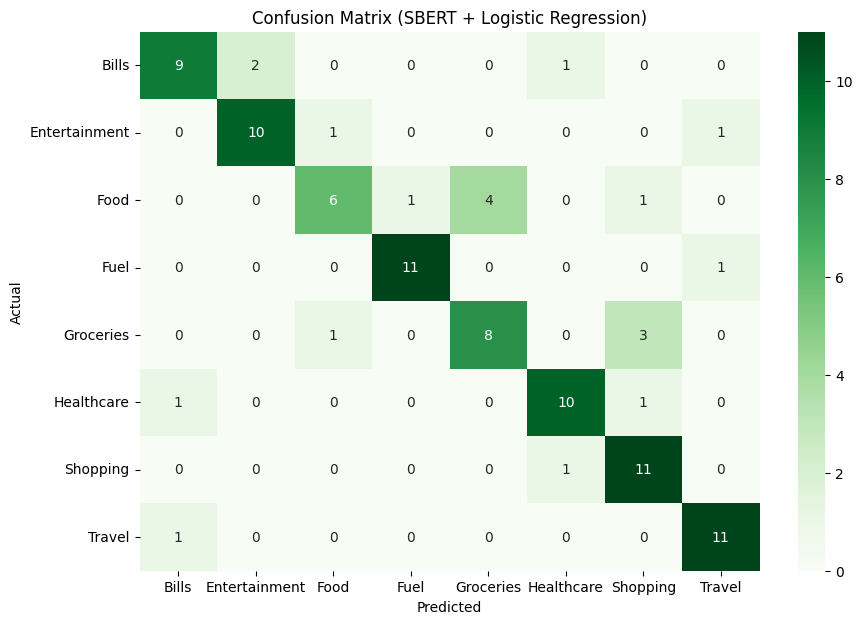

In [12]:
# Cell 8: Evaluate SBERT model performance

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred_sbert = clf.predict(X_test_emb)

# Full classification report
print("=== SBERT Classification Report ===")
print(classification_report(y_test, y_pred_sbert))

# Confusion matrix
labels = sorted(df["category"].unique())
cm = confusion_matrix(y_test, y_pred_sbert, labels=labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (SBERT + Logistic Regression)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


#MiniLM

In [13]:
# CELL 1 — Install Required Libraries for MiniLM
!pip install -q sentence-transformers transformers scikit-learn


In [54]:
# CELL 2 — Import Libraries

from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import torch


In [55]:
# CELL 3 — Load MiniLM Model
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
print("Model loaded successfully!")


Model loaded successfully!


In [56]:
df.head()

,merchant,category
0,Starbucks Coffee,Food
1,McDonalds,Food
2,Subway Sandwich,Food
3,KFC Order,Food
4,Dominos Pizza,Food


In [57]:
# CELL 4 — Convert Merchant Text to MiniLM Embeddings

texts = df['merchant'].astype(str).tolist()
labels = df['category'].astype(str).tolist()

print("Encoding texts... (this may take 10–20 seconds)")

# MiniLM encodes everything at once on GPU/CPU efficiently
embeddings = model.encode(texts, show_progress_bar=True)

embeddings = np.array(embeddings)
labels = np.array(labels)

print("Embeddings shape:", embeddings.shape)


Encoding texts... (this may take 10–20 seconds)


Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Embeddings shape: (477, 384)


In [58]:
# CELL 5 — Train/Test Split

X_train, X_test, y_train, y_test = train_test_split(
    embeddings, labels, test_size=0.2, random_state=42, stratify=labels
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (381, 384)
Test size: (96, 384)


In [59]:
# CELL 6 — Train Classifier (Logistic Regression)

clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)

print("Training completed!")


Training completed!


In [60]:
# CELL 7 — Evaluate Performance

y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

macro_f1 = f1_score(y_test, y_pred, average='macro')
print("Macro F1 Score:", macro_f1)


Classification Report:
               precision    recall  f1-score   support

        Bills       0.82      0.75      0.78        12
Entertainment       0.83      0.83      0.83        12
         Food       0.78      0.58      0.67        12
         Fuel       0.92      0.92      0.92        12
    Groceries       0.73      0.67      0.70        12
   Healthcare       0.83      0.83      0.83        12
     Shopping       0.69      0.92      0.79        12
       Travel       0.85      0.92      0.88        12

     accuracy                           0.80        96
    macro avg       0.81      0.80      0.80        96
 weighted avg       0.81      0.80      0.80        96

Macro F1 Score: 0.7992468944099379


In [30]:
# CELL 8 — Save MiniLM + Classifier

import joblib
import os

os.makedirs("saved_model", exist_ok=True)

model.save("saved_model/minilm_encoder")        # saves embedding model
joblib.dump(clf, "saved_model/minilm_classifier.pkl")  # saves classifier

print("Model saved to saved_model/")


Model saved to saved_model/


In [61]:
# CELL 9 — Prediction Function

def predict_category(text):
    emb = model.encode([text])
    pred = clf.predict(emb)[0]
    prob = np.max(clf.predict_proba(emb))
    return pred, round(prob, 3)

# Test:
predict_category("swgy ordr")


(np.str_('Food'), np.float64(0.218))

#Preprocessing

In [62]:
# CELL A — Basic Cleaning: lowercase, remove numbers, special chars

import re

def basic_clean(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z ]+', ' ', text)     # keep only alphabets and spaces
    text = re.sub(r'\s+', ' ', text)             # collapse multiple spaces
    return text.strip()


In [63]:
# CELL B — Abbreviation Normalization

def normalize_abbreviations(text):
    replace_map = {
        "swgy": "swiggy",
        "zomato": "zomato",
        "zmt": "zomato",

        "brgr": "burger",
        "kng": "king",

        "domnos": "dominos",
        "pzza": "pizza",
        "piza": "pizza",

        "amzn": "amazon",
        "prchs": "purchase",
        "fashn": "fashion",

        "nyka": "nykaa",
        "myntr": "myntra",

        "dmart": "d mart",
        "bazr": "bazaar",

        "hpcl": "hp",
        "iocl": "indian oil",
        "bpcl": "bp",
        "jio bp": "jio bp",

        "petro": "petrol",
        "bunq": "bunk",

        "brdbnd": "broadband",
        "rcrg": "recharge",
        "subscrn": "subscription",
        "mbrshp": "membership",
    }

    for k, v in replace_map.items():
        text = re.sub(rf"\b{k}\b", v, text)

    return text


In [64]:
# CELL C — Brand Normalization

def normalize_brands(text):
    brand_map = {
        "ccd": "cafe coffee day",
        "kfc": "kfc",
        "bk": "burger king",
        "wow momo": "wow momos",

        "flipkart": "flipkart",
        "ajio": "ajio",
        "tatacliq": "tata cliq",

        "irctc": "irctc train ticket",
        "mmt": "make my trip",
        "vistara": "vistara flight",
        "indigo": "indigo flight",

        "netflix": "netflix",
        "yt": "youtube",
        "ps": "playstation",
        "xbox": "xbox",

        "apollo": "apollo pharmacy",
        "medplus": "medplus",

        "big bazr": "big bazaar"
    }

    for k, v in brand_map.items():
        text = text.replace(k, v)

    return text


In [65]:
# CELL D — Keyword Enrichment (adds meaningful hints)

def enrich_keywords(text):
    if "fuel" in text or "petrol" in text or "diesel" in text:
        text += " fuel"
    if "shop" in text or "store" in text or "mart" in text:
        text += " shopping"
    if "hospital" in text or "clinic" in text or "pharmacy" in text:
        text += " healthcare"
    if "ticket" in text or "flight" in text or "train" in text or "bus" in text:
        text += " travel"
    if "subscription" in text or "recharge" in text or "bill" in text:
        text += " bills"
    if "pizza" in text or "burger" in text or "coffee" in text or "food" in text:
        text += " food"
    return text


In [66]:
# CELL E — Final Cleaning Pipeline

def full_clean(text):
    text = basic_clean(text)
    text = normalize_abbreviations(text)
    text = normalize_brands(text)
    text = enrich_keywords(text)
    return basic_clean(text)  # clean again after replacements


In [67]:
# CELL F — Apply complete cleaning
df['clean_merchant'] = df['merchant'].astype(str).apply(full_clean)

df[['merchant', 'clean_merchant']].head(20)


,merchant,clean_merchant
0,Starbucks Coffee,starbucks coffee food
1,McDonalds,mcdonalds
2,Subway Sandwich,subway sandwich
3,KFC Order,kfc order
4,Dominos Pizza,dominos pizza food
5,Pizza Hut,pizza hut food
6,Burger King,burger king food
7,Cafe Coffee Day,cafe coffee day food
8,Chai Point,chai point
9,Wow Momos,wow momoss


In [68]:
# CELL G — Encode cleaned text using MiniLM

texts = df['clean_merchant'].tolist()
labels = df['category'].tolist()

embeddings = model.encode(texts, show_progress_bar=True)


Batches:   0%|          | 0/15 [00:00<?, ?it/s]

In [69]:
# CELL H — Load MiniLM-L12 model (Higher accuracy)
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2")
print("MiniLM-L12 model loaded!")


MiniLM-L12 model loaded!


In [70]:
# CELL I — Encode cleaned merchant text with MiniLM

texts = df['clean_merchant'].astype(str).tolist()
labels = df['category'].astype(str).tolist()

print("Encoding cleaned texts...")

embeddings = model.encode(texts, show_progress_bar=True)
print("Embeddings shape:", embeddings.shape)


Encoding cleaned texts...


Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Embeddings shape: (477, 384)


In [71]:
# CELL J — Train/Test Split (10% test set)

from sklearn.model_selection import train_test_split
import numpy as np

X = np.array(embeddings)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (429, 384)
Test shape: (48, 384)


In [72]:
# CELL K — Train SVM + Calibrated Probabilities

from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

svm = LinearSVC()
clf = CalibratedClassifierCV(svm)

clf.fit(X_train, y_train)

print("Training completed!")


Training completed!


In [78]:
# CELL L — Evaluate Model

from sklearn.metrics import classification_report, f1_score

y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

macro_f1 = f1_score(y_test, y_pred, average='macro')
print("Macro F1 Score:", macro_f1)


Classification Report:
               precision    recall  f1-score   support

        Bills       0.77      0.83      0.80        12
Entertainment       0.85      0.92      0.88        12
         Food       0.79      0.92      0.85        12
         Fuel       1.00      1.00      1.00        12
    Groceries       0.92      1.00      0.96        12
   Healthcare       1.00      1.00      1.00        12
     Shopping       1.00      0.58      0.74        12
       Travel       0.91      0.91      0.91        11

     accuracy                           0.89        95
    macro avg       0.90      0.89      0.89        95
 weighted avg       0.90      0.89      0.89        95

Macro F1 Score: 0.8915108575634891


In [77]:
# CELL N — Prediction Function

import numpy as np

def predict_category(text):
    clean = full_clean(text)
    emb = model.encode([clean])
    pred = clf.predict(emb)[0]
    conf = np.max(clf.predict_proba(emb))
    return pred, round(float(conf), 3)

# Example
predict_category("swgy ordr")


(np.str_('Food'), 0.731)

In [76]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
import numpy as np

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_scores = []

for train_idx, test_idx in skf.split(X, y):

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    svm = LinearSVC()
    clf = CalibratedClassifierCV(svm)
    clf.fit(X_train, y_train)

    preds = clf.predict(X_test)

    f1 = f1_score(y_test, preds, average='macro')
    f1_scores.append(f1)

    print("Fold F1:", f1)

print("\n===== FINAL MACRO F1 SCORE (5-fold) =====")
print("Mean F1:", np.mean(f1_scores))
print("F1 scores per fold:", f1_scores)

Fold F1: 0.847653162055336
Fold F1: 0.8449633699633698
Fold F1: 0.8183160800552105
Fold F1: 0.833179646440516
Fold F1: 0.8915108575634891

===== FINAL MACRO F1 SCORE (5-fold) =====
Mean F1: 0.8471246232155843
F1 scores per fold: [0.847653162055336, 0.8449633699633698, 0.8183160800552105, 0.833179646440516, 0.8915108575634891]
